# Cook It Up with the Fantastic Four

<img src="http://cucinabene.net/wp-content/gallery/ingredients/Sals-Fresh-Ingredients_cropped-for-slider.jpg">

##Table of Contents

* [Notes](#Notes)

* [Part 1 - Data Collection](#Data Collection)
    * [1.1 Train Data](#1.1)
    * [1.2 Test Data](#1.2)

* [Part 2 - Data Cleansing](#Data Cleansing)

* [Part 3 - Exploratory Data Analysis](#EDA)
    * [3.1 Cuisine Distribution in Train Set](#3.1)
    * [3.2 Top 10 Most Used Ingredients in Train Set](#3.2)
    * [3.3 Top 10 Most Used Ingredients in Test Set](#3.3)
    * [3.4 Ingredients Design Matrix for "Ingredients Distribution" plot](#3.4)
    * [3.5 Ingredients Distribution Per Cuisine in Train Set](#3.5)

* [Part 4 - Model Building](#Model Building)
    * [4.1 Build Ingredients Map](#4.1)
    * [4.2 Term-Document Matrix](#4.2)
    * [4.3 SVM Model](#4.3)
    * [4.4 Decision Tree Model](#4.4)
    * [4.5 Random Forest Model](#4.5)

* [Part 5 - Compare Models](#Compare Models)
    * [5.1 Horizontal Plots of Model Performances](#5.1)

* [Part 6 - Plots on Predicted Data](#Plots on Predicated Data)
    * [6.1 Generate Predictions](#6.1)
    * [6.2 Ingredients Distribution in Test Data](#6.2)
    * [6.3 Predicted Cuisine Distribution from Test Data](#6.3)

* [Part 7 - Future Plans: Yummly Integration (Version 0.5.0)](#Future Plans)



<a id='Notes'></a>
#Notes

To make the graphs look more attractive in iPython notebook and to provide interactivity, project team leveraged plotly. There are 2 ways to view plotly results.


1. If you view this notebook on GitHub you would see output of plotly as an image. GiHub has a limitation of not understanding plotly interactive results. To overcome this limitation project team decided to output each plotly result as an image file.

2. To enjoy interactive plots you can:

    a. Visit the project webpage.
    
    b. Download this notebook on your local machine. From "File" menu option select "Trust Notebook". Now you can see all interactive plots on your local machine.  





In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
import plotly.graph_objs as go
from IPython.display import IFrame
plotly.offline.init_notebook_mode() # run at the start of every notebook


<a id='Data Collection'></a>
# Part 1 - Data Collection <img src = "https://media.licdn.com/mpr/mpr/p/6/005/087/3da/1265b9a.jpg" width="150">

<a id='1.1'></a>
### 1.1 Train Data

In [46]:
# Kaggle provided training set and test set in json format. 
train_df = pd.read_json("train.json") # build a dataframe from the training json file.
df_sample = train_df[5:10]
table = FF.create_table(df_sample)
py.iplot(table, filename='pandas_table') #Plotly used to display sample records from training set.

In [47]:
train_df.head()

cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...

<a id='1.2'></a>
### 1.2 Test Data

In [3]:
test_df = pd.read_json("test.json") # build a dataframe from the test json file.
df_sample = test_df[0:5]
table = FF.create_table(df_sample)
py.iplot(table, filename='pandas_table')  #Plotly used to display sample records from test set.

In [48]:
test_df.head()

id                                        ingredients       cuisine
0  18009  [baking powder, eggs, all-purpose flour, raisi...   southern_us
1  28583  [sugar, egg yolks, corn starch, cream of tarta...   southern_us
2  41580  [sausage links, fennel bulb, fronds, olive oil...       italian
3  29752  [meat cuts, file powder, smoked sausage, okra,...  cajun_creole
4  35687  [ground black pepper, salt, sausage casings, l...       italian

<a id='Data Cleansing'></a>
# Part 2 - Data Cleansing  <img src="http://www.originlists.com/images/cleansing.jpg" width=250>

In [4]:
import nltk # NLTK - Natural language toolkit used for data cleansing.
import re
from nltk.stem import WordNetLemmatizer
from collections import Counter
stemmer = WordNetLemmatizer()

In [5]:
# Function created to cleanse data.
# Input parameter - list of ingredients.
# Output - cleansed list of ingredients.
def clean_recipe(recipe):
    # To lowercase.
    recipe = [ i for i in recipe ]
    
    # Function to replace special characters with a space.
    def replacing(i):
        i = i.replace('&', '').replace('(', '').replace(')','')
        i = i.replace('\'', '').replace('\\', '').replace(',','')
        i = i.replace('.', '').replace('%', '').replace('/','')
        i = i.replace('"', '')
        
        return i
    
    recipe = [ replacing(i) for i in recipe ] # Function "replacing" applied on ingredients list.
    
    recipe = [ i for i in recipe if not i.isdigit() ] # Remove digits.
    
    recipe = [ stemmer.lemmatize(i) for i in recipe ] # Returns input word unchanged if not found in WordNetLemmatizer.
    
    return recipe

In [6]:
%%time

# Function clean_recipe called on training data.
train_df['ingredients'] = train_df.ingredients.apply(lambda x: clean_recipe(x))

CPU times: user 8.54 s, sys: 163 ms, total: 8.7 s
Wall time: 8.72 s


<a id='EDA'></a>
##  Part 3 - Exploratory Data Analysis <img src="https://d3njjcbhbojbot.cloudfront.net/api/utilities/v1/imageproxy/https://d15cw65ipctsrr.cloudfront.net/09/b15db069b611e389c8cb045191a2cf/ExploratoryDataAnalysis.jpg" width=300>

<a id='3.1'></a>
### 3.1 Cuisine Distribution in Train Set

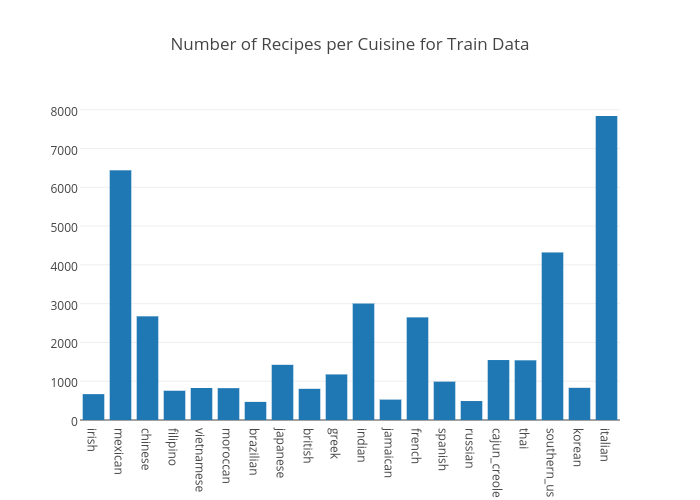

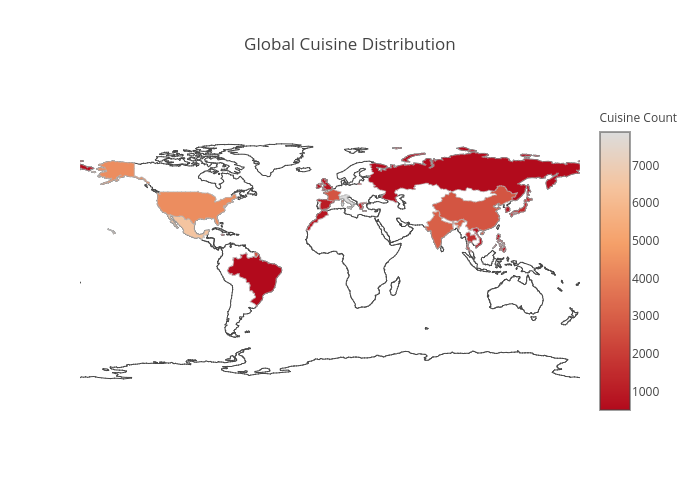

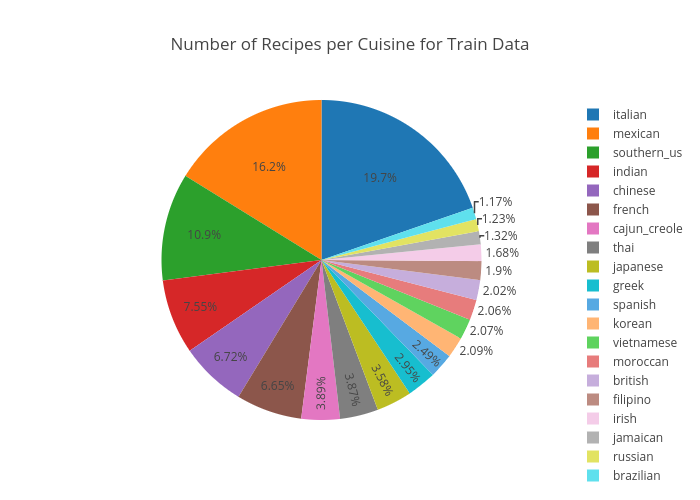

In [39]:
# EDA on Training data.

from collections import Counter

# Find Cuisine Distribution
countdict = Counter(train_df.cuisine)
cuisines = countdict.keys()
cuisinescount = countdict.values()

# Plot Cuisine Distribution Bar Chart
data = [
    go.Bar(
        y=cuisinescount,
        x=cuisines,    
    )
]
layout = dict(
    title='Number of Recipes per Cuisine for Train Data',
)
fig = go.Figure(data=data , layout=layout)


# Creating Pie Chart
fig2 = {
    'data': [{'labels': cuisines,
              'values': cuisinescount,
              'type': 'pie'}],
    'layout': {'title': 'Number of Recipes per Cuisine for Train Data'}
}

# Plot Global Cuisine Distribution

myList=[]

for c in cuisines: 
    if c == 'brazilian':
        myList.append('BRA')
    elif c == 'british':
        myList.append('GBR')
    elif c == 'cajun_creole':
        myList.append('USA')
    elif c == 'chinese':
        myList.append('CHN')
    elif c == 'filipino':
        myList.append('PHL')
    elif c == 'french':
        myList.append('FRA')
    elif c == 'greek':
        myList.append('GRC')
    elif c == 'indian':
        myList.append('IND')
    elif c == 'irish':
        myList.append('IRL')
    elif c == 'italian':
        myList.append('ITA')
    elif c == 'jamaican':
        myList.append('JAM')
    elif c == 'japanese':
        myList.append('JPN')
    elif c == 'korean':
        myList.append('KOR')
    elif c == 'mexican':
        myList.append('MEX')
    elif c == 'moroccan':
        myList.append('MAR')
    elif c == 'russian':
        myList.append('RUS')
    elif c == 'southern_us':
        myList.append('USA')
    elif c == 'spanish':
        myList.append('ESP')
    elif c == 'thai':
        myList.append('THA')
    elif c == 'vietnamese':
        myList.append('VNM')

data3 = [ dict(
        type = 'choropleth',
        locations = myList,
        z = cuisinescount,
        text = cuisines,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = True,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            )
        ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Cuisine Count'
        ),
    ) ]

layout3 = dict(
    title = 'Global Cuisine Distribution',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
fig3 = dict( data=data3, layout=layout3 )

iplot(fig)
iplot(fig2)
iplot(fig3, validate=False)



# The code below is to display the static image of the plot
py.image.save_as({'data': data,'layout': layout}, 'Number of Recipes per Cuisine for Train Data Histogram.png')
py.image.save_as({'data': data3,'layout': layout3}, 'Number of Recipes per Cuisine for Train Data Pie Chart.png')
py.image.save_as({
    'data': [{'labels': cuisines,
              'values': cuisinescount,
              'type': 'pie'}],
    'layout': {'title': 'Number of Recipes per Cuisine for Train Data'}
}, 'Global Cuisine Distribution Train Data.png')


py.image.ishow({'data': data,'layout': layout})
py.image.ishow({'data': data3,'layout': layout3})
py.image.ishow({
    'data': [{'labels': cuisines,
              'values': cuisinescount,
              'type': 'pie'}],
    'layout': {'title': 'Number of Recipes per Cuisine for Train Data'}
})


<a id='3.2'></a>
### 3.2 Top 10 Most Used Ingredients in Train Set

In [8]:
%%time

# Find Ingredient Distribution
recipe_ingredient = [Counter(clean_recipe(recipe)) for recipe in train_df.ingredients] 
ingredient_distribution = sum(recipe_ingredient, Counter())

CPU times: user 4min 30s, sys: 3.91 s, total: 4min 34s
Wall time: 4min 37s


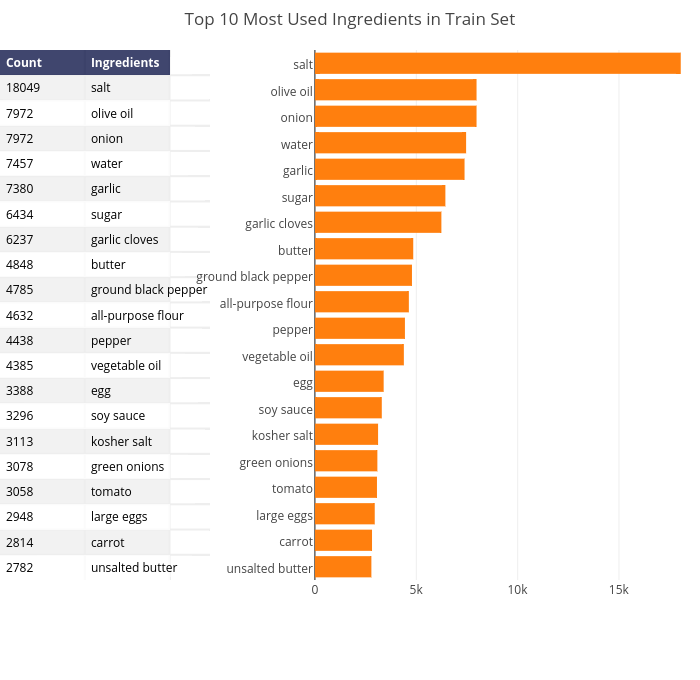

CPU times: user 950 ms, sys: 69.5 ms, total: 1.02 s
Wall time: 3.96 s


In [40]:
%%time

ingredient_fig = pd.DataFrame(ingredient_distribution, index=[0]).transpose()[0].sort(ascending=False, inplace=False)
table = FF.create_table(pd.DataFrame({ 'Ingredients' :ingredient_fig[:20].keys(), 'Count' : ingredient_fig[:20].values}))

# Find Cuisine Distribution - train set
ingredients = ingredient_fig[:20].keys()
ingredientscount = ingredient_fig[:20].values
ingredients = ingredients[::-1]
ingredientscount = ingredientscount[::-1]

# Plot Cuisine Distribution - train set
data = [
    go.Bar(
        x=ingredientscount,
        y=ingredients,
        orientation = 'h',
        xaxis='x2', yaxis='y2'
    )
]
table['data'].extend(data)

# Edit layout for subplots - train set
table.layout.xaxis.update({'domain': [0, .3]})
table.layout.xaxis2.update({'domain': [0.45, 1.]})

# The graph's y axis MUST BE anchored to the graph's x axis - train set
table.layout.yaxis2.update({'anchor': 'x2'})

# Update the margins to add a title and see graph x-labels - train set
table.layout.margin.update({'t':50, 'b':100})
table.layout.update({'title': 'Top 10 Most Used Ingredients in Train Set'})

iplot(table)


# The code below is to display the static image of the plot
py.image.save_as(table, 'Top 10 Most Used Ingredients in Train Set.png')
py.image.ishow(table)


<a id='3.3'></a>
### 3.3 Top 10 Most Used Ingredients in Test Set

In [10]:
%%time
recipe_ingredienttest = [Counter(clean_recipe(recipe)) for recipe in test_df.ingredients]
ingredient_distributiontest = sum(recipe_ingredienttest, Counter())

CPU times: user 35.9 s, sys: 521 ms, total: 36.4 s
Wall time: 36.5 s


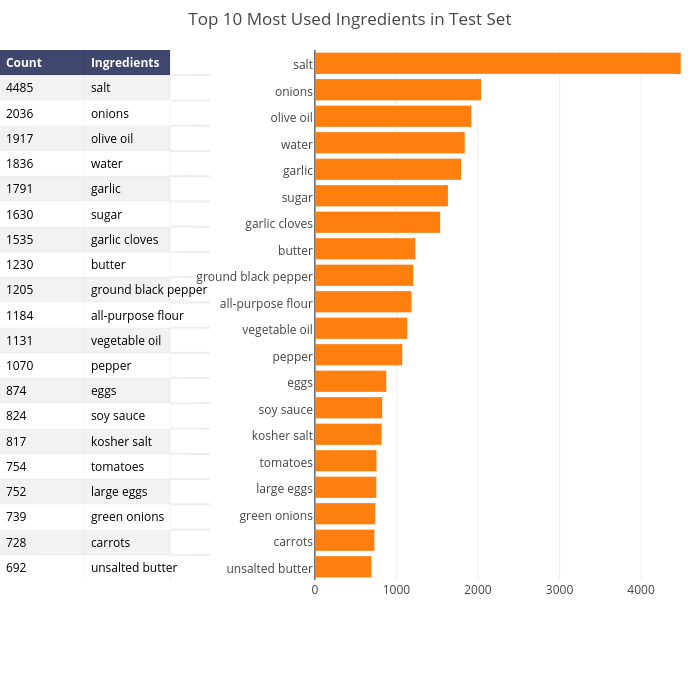

In [41]:
ingredient_figtest = pd.DataFrame(ingredient_distributiontest, index=[0]).transpose()[0].sort(ascending=False, inplace=False)
table = FF.create_table(pd.DataFrame({ 'Ingredients' :ingredient_figtest[:20].keys(), 'Count' : ingredient_figtest[:20].values}))

# Find Cuisine Distribution - test set
ingredientstest = ingredient_figtest[:20].keys()
ingredientscounttest = ingredient_figtest[:20].values
ingredientstest = ingredientstest[::-1]
ingredientscounttest = ingredientscounttest[::-1]

# Plot Cuisine Distribution - test set
data = [
    go.Bar(
        x=ingredientscounttest,
        y=ingredientstest,
        orientation = 'h',
        xaxis='x2', yaxis='y2'
    )
]
table['data'].extend(data)

# Edit layout for subplots - test set
table.layout.xaxis.update({'domain': [0, .3]})
table.layout.xaxis2.update({'domain': [0.45, 1.]})

# The graph's y axis MUST BE anchored to the graph's x axis - test set
table.layout.yaxis2.update({'anchor': 'x2'})

# Update the margins to add a title and see graph x-labels - test set
table.layout.margin.update({'t':50, 'b':100})
table.layout.update({'title': 'Top 10 Most Used Ingredients in Test Set'})

iplot(table)


# The code below is to display the static image of the plot
py.image.save_as(table, 'Top 10 Most Used Ingredients in Test Set.png')
py.image.ishow(table)


<a id='3.4'></a>
### 3.4 Ingredients Design Matrix for "Ingredients Distribution" plot

This design matrix is created for building plots. Later we also have another deisgn matrix build for modelling purpose.  

In [12]:
%%time

# The number of times each ingredient is used is stored in the 'sumbags' dictionary
bags_of_words = [ Counter(clean_recipe(recipe)) for recipe in train_df.ingredients ] 
sumbags = sum(bags_of_words, Counter())

CPU times: user 4min 39s, sys: 3.78 s, total: 4min 43s
Wall time: 4min 47s


In [13]:
%%time

# Design matrix consists of the cuisine and the correspding count of ingredients. 

ingredientdf = train_df

for ingredient in list(sumbags.keys()):
    ingredientdf[ingredient] = ingredientdf.ingredients.apply(lambda x: ingredient in x)

cuisine = ingredientdf.drop(['ingredients', 'id'], axis=1).groupby('cuisine')
cuisine = cuisine.aggregate(np.sum)



CPU times: user 3min 5s, sys: 10.1 s, total: 3min 16s
Wall time: 3min 17s


In [14]:
cuisine.head() # display of design matrix

low-sodium fat-free chicken broth  sweetened coconut  \
cuisine                                                              
brazilian                                     0                  1   
british                                       0                  0   
cajun_creole                                  2                  0   
chinese                                       1                  1   
filipino                                      0                  0   

              baking chocolate  egg roll wrappers  bottled low sodium salsa  \
cuisine                                                                       
brazilian                    0                  0                         0   
british                      0                  0                         0   
cajun_creole                 0                  0                         0   
chinese                      0                 38                         0   
filipino                     0                  3                         0   

              vegan parmesan cheese  clam sauce  sushi nori  broiler  \
cuisine                                                                
brazilian                         0           0           0        0   
british                           0           0           0        0   
cajun_creole                      0           0           0        0   
chinese                           0           0           0        0   
filipino                          0           0           0        0   

              jalapeno chilies           ...             chioggia  \
cuisine                                  ...                        
brazilian                   19           ...                    0   
british                      1           ...                    0   
cajun_creole                49           ...                    0   
chinese                     20           ...                    0   
filipino                    11           ...                    0   

              red leaf lettuce  margarita salt  \
cuisine                                          
brazilian                    0               0   
british                      0               0   
cajun_creole                 0               0   
chinese                      1               0   
filipino                     0               0   

              low sodium canned chicken broth  \
cuisine                                         
brazilian                                   0   
british                                     0   
cajun_creole                                0   
chinese                                     0   
filipino                                    0   

              progresso reduced sodium chicken broth  seedless raspberry jam  \
cuisine                                                                        
brazilian                                          0                       0   
british                                            0                       1   
cajun_creole                                       1                       0   
chinese                                            0                       0   
filipino                                           0                       0   

              steamed white rice  black radish  cinnamon ice cream  \
cuisine                                                              
brazilian                      0             0                   0   
british                        0             0                   0   
cajun_creole                   5             0                   0   
chinese                       15             0                   0   
filipino                       2             0                   0   

              lower sodium beef broth  
cuisine                                
brazilian                           0  
british                             1  
cajun_creole                        0  
chinese                          

<a id='3.5'></a>
### 3.5 Ingredients Distribution Per Cuisine in Train Set

In [17]:
%%time

# Find Cuisine Distribution
ingredients = ingredient_fig[:10].keys()
ingredientscount = ingredient_fig[:10].values

CPU times: user 285 µs, sys: 49 µs, total: 334 µs
Wall time: 320 µs


(u'brazilian', u'british', u'cajun_creole', u'chinese', u'filipino', u'french', u'greek', u'indian', u'irish', u'italian', u'jamaican', u'japanese', u'korean', u'mexican', u'moroccan', u'russian', u'southern_us', u'spanish', u'thai', u'vietnamese')
This is the format of your plot grid:
[ (1,1) x1,y1 ]     [ (1,2) x2,y2 ]   
[ (2,1) x3,y3 ]     [ (2,2) x4,y4 ]   
[ (3,1) x5,y5 ]     [ (3,2) x6,y6 ]   
[ (4,1) x7,y7 ]     [ (4,2) x8,y8 ]   
[ (5,1) x9,y9 ]     [ (5,2) x10,y10 ] 
[ (6,1) x11,y11 ]   [ (6,2) x12,y12 ] 
[ (7,1) x13,y13 ]   [ (7,2) x14,y14 ] 
[ (8,1) x15,y15 ]   [ (8,2) x16,y16 ] 
[ (9,1) x17,y17 ]   [ (9,2) x18,y18 ] 
[ (10,1) x19,y19 ]  [ (10,2) x20,y20 ]



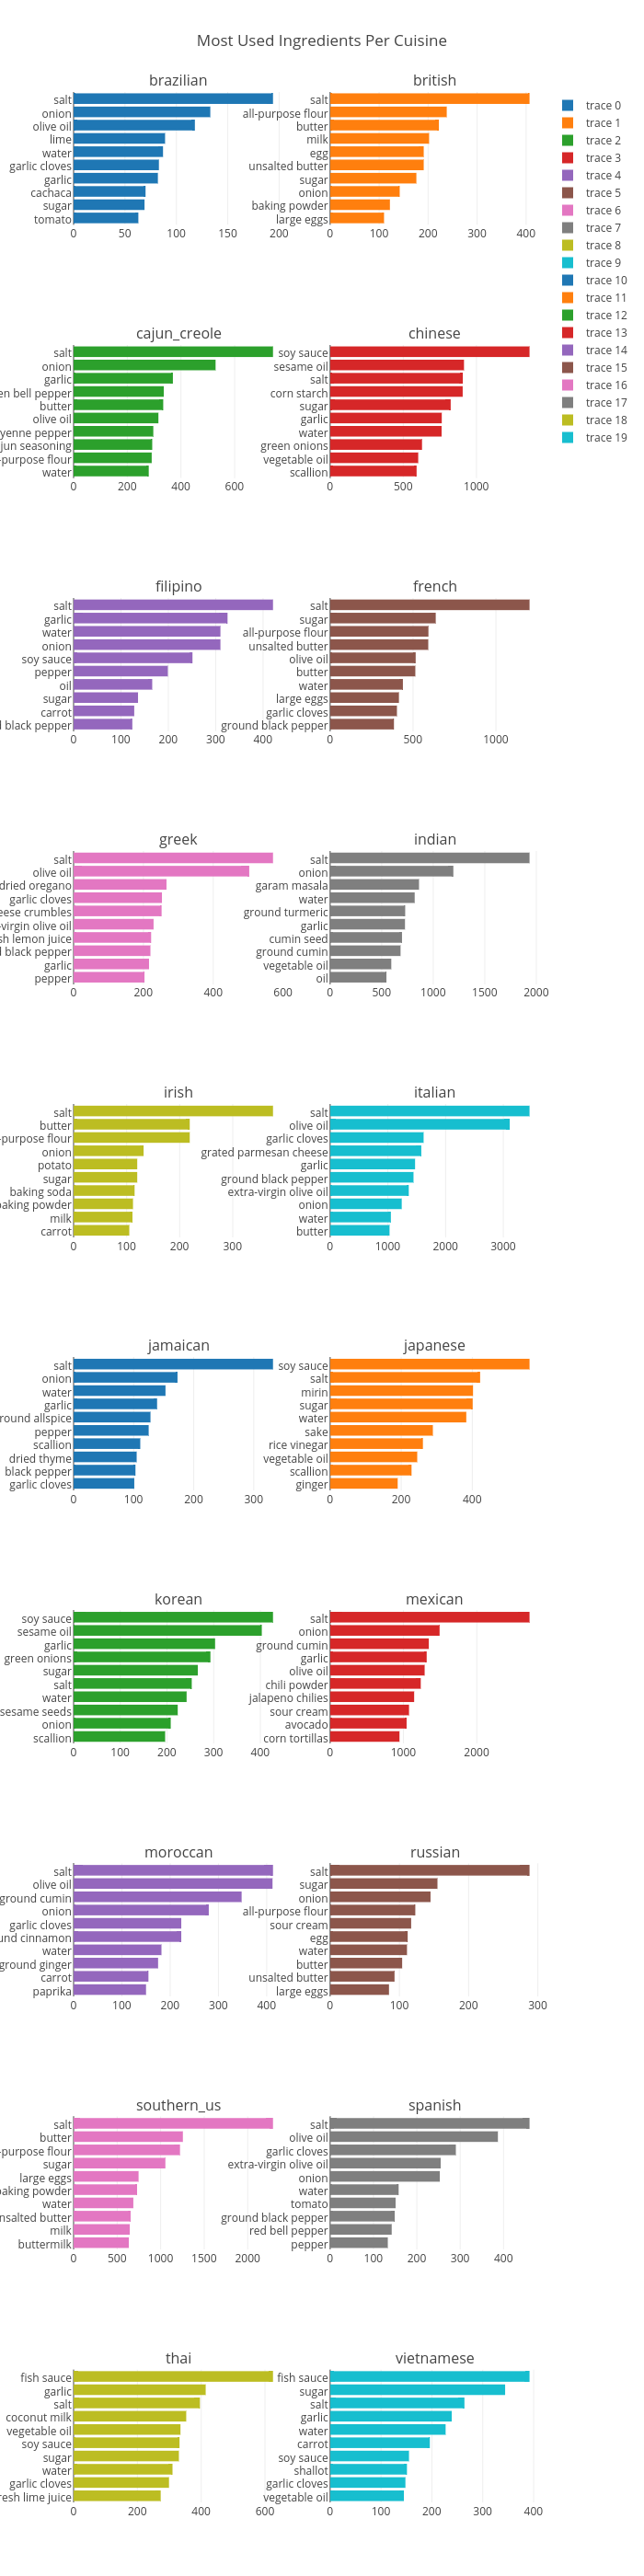

CPU times: user 981 ms, sys: 60.7 ms, total: 1.04 s
Wall time: 7.23 s


In [49]:
%%time

# For each cuisine plot top ingredients.
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

nametuple = ();
for i, c in enumerate(list(cuisine.index)):
    nametuple = nametuple + (c,)

print nametuple

fig = tools.make_subplots(rows=10, cols=2, subplot_titles = nametuple)

for i, c in enumerate(list(cuisine.index)):    
    originalx =  cuisine.loc[c].sort(inplace=False, ascending=False)[:10].values
    originaly =  cuisine.loc[c].sort(inplace=False, ascending=False)[:10].keys()
    trace0 = go.Bar(
            x = originalx[::-1],
            y = originaly[::-1],
            orientation = 'h'
        )
    if i == 0:
        fig.append_trace(trace0, 1, 1)
    elif i == 1:
        fig.append_trace(trace0, 1, 2)        
    elif i == 2:
        fig.append_trace(trace0, 2, 1)        
    elif i == 3:
        fig.append_trace(trace0, 2, 2)        
    elif i == 4:
        fig.append_trace(trace0, 3, 1)       
    elif i == 5:
        fig.append_trace(trace0, 3, 2)       
    elif i == 6:
        fig.append_trace(trace0, 4, 1)       
    elif i == 7:
        fig.append_trace(trace0, 4, 2)
    elif i == 8:
        fig.append_trace(trace0, 5, 1)
    elif i == 9:
        fig.append_trace(trace0, 5, 2)        
    elif i == 10:
        fig.append_trace(trace0, 6, 1)        
    elif i == 11:
        fig.append_trace(trace0, 6, 2)        
    elif i == 12:
        fig.append_trace(trace0, 7, 1)       
    elif i == 13:
        fig.append_trace(trace0, 7, 2)       
    elif i == 14:
        fig.append_trace(trace0, 8, 1)       
    elif i == 15:
        fig.append_trace(trace0, 8, 2)
    elif i == 16:
        fig.append_trace(trace0, 9, 1)        
    elif i == 17:
        fig.append_trace(trace0, 9, 2)       
    elif i == 18:
        fig.append_trace(trace0, 10, 1)       
    elif i == 19:
        fig.append_trace(trace0, 10, 2)       

fig['layout'].update(height=2800,
                     title='Most Used Ingredients Per Cuisine')
iplot(fig)


# The code below is to display the static image of the plot
py.image.save_as(fig, 'Most Used Ingredients Per Cuisine Train Set.png')
py.image.ishow(fig)

In [19]:
ingredients_all = []
for i in ingredients:
    ingredients_all.append(i)    
cuisinefeatures=np.unique(ingredients_all) #create a feature list of unique ingrediants.

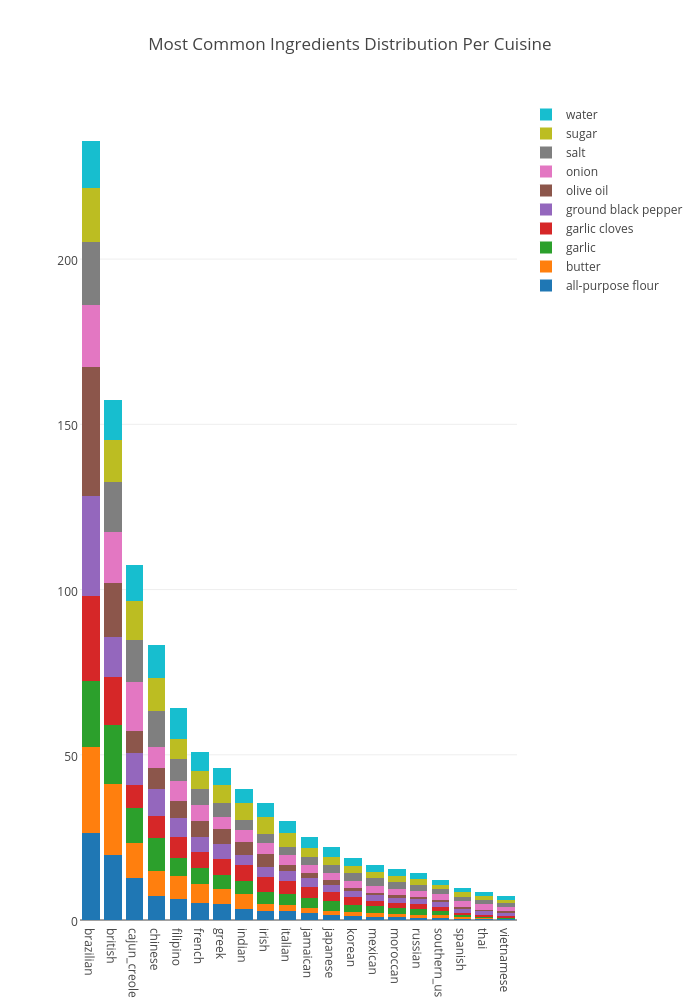

In [51]:
# For each cuisine plot bar chart of top ingredients.

data = []
    
for col in cuisinefeatures:
    if col != 'cuisine':
        total = np.sum(cuisine[col].sort(inplace=False, ascending=False)[:20].values)
        data.append(
            go.Bar( 
                    x = list(cuisine.index),
                    y = cuisine[col].sort(inplace=False, ascending=False)[:20].values/total * 100,
                    name = col ) )

layout = go.Layout(
    title='Most Common Ingredients Distribution Per Cuisine',
    barmode='stack',
    height = 1000
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)


# The code below is to display the static image of the plot
py.image.save_as(fig, 'Most Common Ingredients Distribution Per Cuisine Stack Train Data.png')
py.image.ishow(fig)


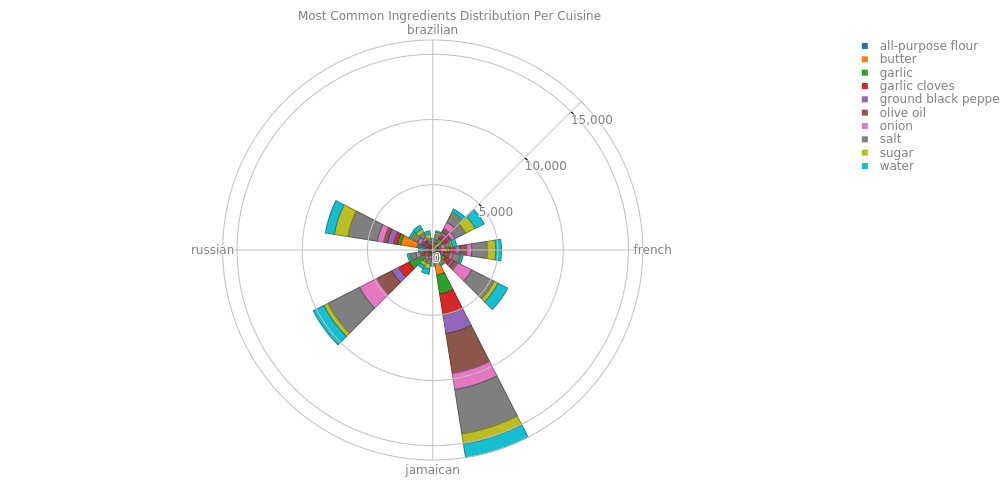

In [53]:
# For each cuisine plot pie chart of top ingredients.
import pandas as pd
import colorlover as cl
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go

data = []
counter = 0

for col in cuisinefeatures:
    if col != 'cuisine':
        data.append(
            go.Area(t=list(cuisine.index),
                    r=cuisine[col],
                    name=col))
        counter+=1

layout = go.Layout(
    title='Most Common Ingredients Distribution Per Cuisine',
    barmode='stack',
    orientation=270,
    width=1000


)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

# The code below is to display the static image of the plot
py.image.save_as(fig, 'Most Common Ingredients Distribution Per Cuisine Pie.png')
py.image.ishow(fig)


<a id='Model Building'></a>
#  Part 4 - Model Building <img src="https://d3njjcbhbojbot.cloudfront.net/api/utilities/v1/imageproxy/https://d15cw65ipctsrr.cloudfront.net/a3/816f2069b611e3af9a07984d9d273b/PredictionMachineLearning.jpg" width=300>

<a id='4.1'></a>
### 4.1 Build Ingredients Map

In [23]:
%%time
# list of all possible ingredients.

ingredients_all=[]

for i in train_df['ingredients']:
    for j in xrange(len(i)):
        ingredients_all.append(i[j])
        
for i in test_df['ingredients']:
    for j in xrange(len(i)):
        ingredients_all.append(i[j])

features=np.unique(ingredients_all) #create a feature list of unique ingrediants.

ingredients_map={v:k for k,v in enumerate(np.unique(ingredients_all).tolist())} #assign key to each ingredient

CPU times: user 1.74 s, sys: 299 ms, total: 2.04 s
Wall time: 2.11 s


<a id='4.2'></a>
### 4.2 Term-Document Matrix

This design matrix builds a column for each ingredient. For each incoming list of ingredients (from train or test set) we mark 1 for the corresponding ingredient in the matrix. This matrix becomes X for each classifier modelled.

In [24]:
# Function created to build deign matrix for input dataframe.
# Input parameter - dataframe name. In our case this will be either train dataframe or test dataframe.
# Output - Design Matrix.

def build_designmatrix(indf):
    
    designmatrix=np.zeros((len(indf), len(features))) 
    all_ids = indf['id'] #list of all id's from input set.
    
    #build design matrix
    for i in xrange(len(indf)):
        for j in indf['ingredients'][indf['id']==all_ids[i]]:
                for k in xrange(len(j)):
                        designmatrix[i, ingredients_map[j[k]]] = 1
                        
    return designmatrix

In [25]:
import time
start_time = time.time()

#Create X and Y value for training the classifiers.
X = build_designmatrix(train_df)
y = train_df['cuisine']

print("--- %s seconds ---" % (time.time() - start_time))




--- 38.9932072163 seconds ---


In [26]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic optimization function from CS-109 labs
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [27]:
# Create test/train mask
itrain, itest = train_test_split(xrange(train_df.shape[0]), train_size=0.6)
mask=np.ones(train_df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

We considered various classifiers for modelling of which SVM, Decision Tree and Random Forest stood out for text analysis. Hence we ran these 3 classifiers for comparing accuracy and performance. We also tried AdaBoostingClassifier and GradientBoostingClassifier. The runtime for these 2 classifiers was way too long which resulted in eliminating these 2 classifiers (based on performance). 

<a id='4.3'></a>
### 4.3 SVM Model <img src="http://i.stack.imgur.com/zeRTm.png" width=300>

In [28]:
import time
start_time = time.time()

from sklearn.svm import LinearSVC
clfsvm=LinearSVC(loss="hinge")
parameters = {"C": [0.0001,0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clf = cv_optimize(clfsvm, parameters, Xtrain, ytrain, n_folds=5, score_func='f1_weighted')
clf=clf.fit(Xtrain, ytrain)
training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)


print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

clfsvm = clf
svc_training_accuracy = training_accuracy
svc_test_accuracy = test_accuracy

svcTrainTime = round(time.time() - start_time)
print svcTrainTime

BEST {'C': 1.0} 0.750504698842 [mean: 0.36746, std: 0.00435, params: {'C': 0.0001}, mean: 0.56687, std: 0.00782, params: {'C': 0.001}, mean: 0.66661, std: 0.00589, params: {'C': 0.01}, mean: 0.74896, std: 0.00605, params: {'C': 0.1}, mean: 0.75050, std: 0.00564, params: {'C': 1.0}, mean: 0.70607, std: 0.00553, params: {'C': 10.0}, mean: 0.66197, std: 0.00746, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.92
Accuracy on test data:     0.76
[[ 118    1    2    3    8    1    1    4    2   11    1    1    0   26
     0    2    9    2    4    1]
 [   1  125    3    2    2   46    5    7   29   34    3    1    1    7
     2    8   48    3    1    4]
 [   4    6  419    3    3   15    2    4    2   24    1    1    0   11
     4    7   82    7    0    1]
 [   1    0    8  891   11    8    0    7    2   15    0   32   29    7
     3    6   10    1   26   18]
 [   6    3    0   28  186    4    2    7    6   10    1    4    4    6
   

/Users/angelhenderson/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



<a id='4.4'></a>
### 4.4 Decision Tree Model <img src="https://littleml.files.wordpress.com/2013/04/traditional.png" width=300>

A decision tree aims at minimizing entropy. Entropy is a measure of chaos; something that is very ordered has a very low entropy, something that is very messy has a very high entropy. A decision tree is structure that resembles a flow chart. Every node in the tree represents a decision that needs to be taken for determining the class. Based on the training data the most relevant features and their values are selected for lowering the entropy of the data set. In contrast to many other approaches to classification, decision trees are easy to interpret by humans. Though decision trees are mainly used for classification, they can also be used for regression.

In [29]:
start_time = time.time()
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()
parameters = {"max_depth": [None], 'min_samples_leaf': [4, 5, 6]}

clf = cv_optimize(clfTree1, parameters, Xtrain, ytrain, n_jobs=1, n_folds=5, score_func='f1_weighted')
clf=clf.fit(Xtrain, ytrain)
    
training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

Decision_Tree_training_accuracy = training_accuracy
Decision_Tree_test_accuracy = test_accuracy
clfDecisionTree = clf

dtTrainTime = round(time.time() - start_time)
print dtTrainTime

BEST {'max_depth': None, 'min_samples_leaf': 6} 0.563562189217 [mean: 0.56281, std: 0.00626, params: {'max_depth': None, 'min_samples_leaf': 4}, mean: 0.56155, std: 0.00626, params: {'max_depth': None, 'min_samples_leaf': 5}, mean: 0.56356, std: 0.00590, params: {'max_depth': None, 'min_samples_leaf': 6}]
############# based on standard predict ################
Accuracy on training data: 0.69
Accuracy on test data:     0.58
[[  56    6    4    1   10    4    3    9    4   23    3    6    0   35
     1    2   21    2    6    1]
 [   1   58    7    1    1   65    3    5   17   68    2    3    0    9
     1    5   80    5    0    1]
 [   4    3  287    9    3   36    2   12    9   62   11    2    2   50
     5    1   87    8    2    1]
 [   0    3    9  764   13   15    4   19    7   36    5   67   35   26
     1    1   24    0   36   10]
 [   5   10    3   39  103    9    1    8    7   23   12    8    5   16
     0    0   24    2   22    5]
 [   2   33   33   18    2  400    5   16   24 

<a id='4.5'></a>
### 4.5 Random Forest Model <img src ="http://cdn-ak.f.st-hatena.com/images/fotolife/k/kazoo04/20131204/20131204173330.png" width=350>

A random forest is a model ensemble. An ensemble combines multiple models to achieve better results than a single model would. A random forest consists of multiple decision trees. Each tree in the forest has a different random subset of the features (subspace sampling) and the trees are fed with different subsets of the training data (bagging). Though a random forest gives more accurate results than a single decision tree, it is harder to read and takes more computational time to generate.



In [30]:
start_time = time.time()
from sklearn.ensemble import RandomForestClassifier
clfForest = RandomForestClassifier()
parameters = {"n_estimators": range(1, 20)}

clf = cv_optimize(clfForest, parameters, Xtrain, ytrain, n_jobs=1, n_folds=5, score_func='f1_weighted')
clf=clf.fit(Xtrain, ytrain)

training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)

print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

Random_Forest_training_accuracy = training_accuracy
Random_Forest_test_accuracy = test_accuracy
clfRandomForest = clf

rfTrainTime = round(time.time() - start_time)
print rfTrainTime

BEST {'n_estimators': 19} 0.651732126347 [mean: 0.45904, std: 0.01688, params: {'n_estimators': 1}, mean: 0.45979, std: 0.00383, params: {'n_estimators': 2}, mean: 0.51748, std: 0.00691, params: {'n_estimators': 3}, mean: 0.56218, std: 0.01060, params: {'n_estimators': 4}, mean: 0.57559, std: 0.00487, params: {'n_estimators': 5}, mean: 0.59179, std: 0.00560, params: {'n_estimators': 6}, mean: 0.60405, std: 0.00710, params: {'n_estimators': 7}, mean: 0.61427, std: 0.00815, params: {'n_estimators': 8}, mean: 0.62200, std: 0.00570, params: {'n_estimators': 9}, mean: 0.62160, std: 0.00578, params: {'n_estimators': 10}, mean: 0.63202, std: 0.00586, params: {'n_estimators': 11}, mean: 0.62986, std: 0.00957, params: {'n_estimators': 12}, mean: 0.63971, std: 0.00590, params: {'n_estimators': 13}, mean: 0.64186, std: 0.00378, params: {'n_estimators': 14}, mean: 0.64427, std: 0.00562, params: {'n_estimators': 15}, mean: 0.64734, std: 0.00407, params: {'n_estimators': 16}, mean: 0.64652, std: 0.0

<a id='Compare Models'></a>
#  Part 5 - Compare Models

<a id='5.1'></a>
### 5.1 Horizontal Plots of Model Performances

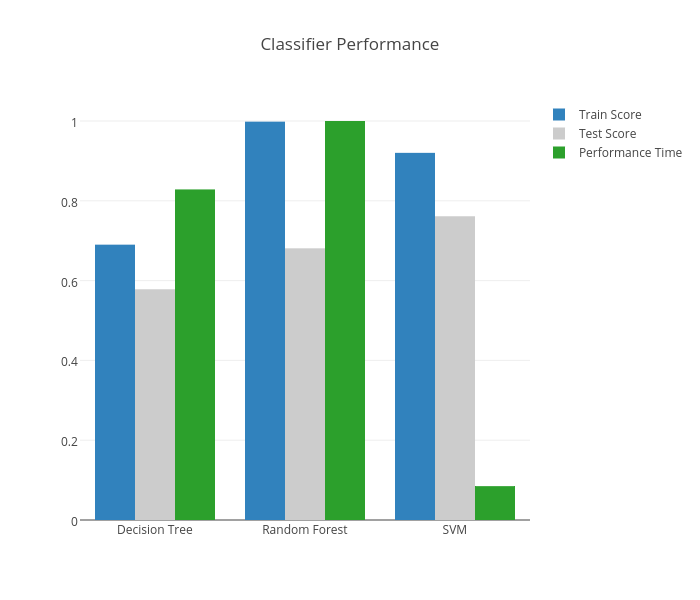

In [54]:
# This plot compares performance and accuracy of the 3 classifiers.
# Y axis for this plot has been scaled from 0 to 1 for easier comparison.
# 3 separate colors are used for performance, training accuracy and test accuracy.

import plotly.plotly as py
import plotly.graph_objs as go

timeList = [dtTrainTime, rfTrainTime, svcTrainTime]
longestTime = max(timeList)

dfTimePercentage = dtTrainTime/longestTime
rfTimePercentage = rfTrainTime/longestTime
svcTimePercentage = svcTrainTime/longestTime


trace0 = go.Bar(
    x=['Decision Tree', 'Random Forest', 'SVM'],
    y=[Decision_Tree_training_accuracy, Random_Forest_training_accuracy, svc_training_accuracy],
    name='Train Score',
    marker=dict(
        color='rgb(49,130,189)'
    )
)
trace1 = go.Bar(
    x=['Decision Tree', 'Random Forest', 'SVM'],
    y=[Decision_Tree_test_accuracy, Random_Forest_test_accuracy, svc_test_accuracy],
    name='Test Score',
    marker=dict(
        color='rgb(204,204,204)',
    )
)

trace2 = go.Bar(
    x=['Decision Tree', 'Random Forest', 'SVM'],
    y=[dfTimePercentage, rfTimePercentage, svcTimePercentage],
    name='Performance Time'
)


data = [trace0, trace1, trace2]
layout = go.Layout(
    xaxis=dict(
        # set x-axis' labels direction at 45 degree angle
        tickangle=0,
    ),
    barmode='group',
    title='Classifier Performance',
    height = 600
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)


# The code below is to display the static image of the plot
py.image.save_as(fig, 'Classifier Performance.png')
py.image.ishow(fig)


<a id='Plots on Predicated Data'></a>
#  Part 6 - Plots on Predicated Data

<a id='6.1'></a>
### 6.1 Generate Predictions

In [32]:
%%time

# Create X value (Design Matrix) for test set.
Xfinal = build_designmatrix(test_df)

# Since SVM came out as the better classifier we will predict on test set using SVM.
ypred=clfsvm.predict(Xfinal)

CPU times: user 6.91 s, sys: 442 ms, total: 7.35 s
Wall time: 6.74 s


In [33]:
# Generate final prediction (SVM_submission.csv)
test_df['cuisine']=ypred
test_df.to_csv("SVM_submission.csv")

<a id='6.2'></a>
### 6.2 Ingredients Distribution in Test Data

In [34]:
%%time
recipe_ingredienttest = [Counter(recipe) for recipe in test_df.ingredients]
ingredient_distributiontest = sum(recipe_ingredienttest, Counter())

CPU times: user 36.3 s, sys: 954 ms, total: 37.3 s
Wall time: 37.5 s


<a id='6.3'></a>
### 6.3 Predicted Cuisine Distribution from Test Data

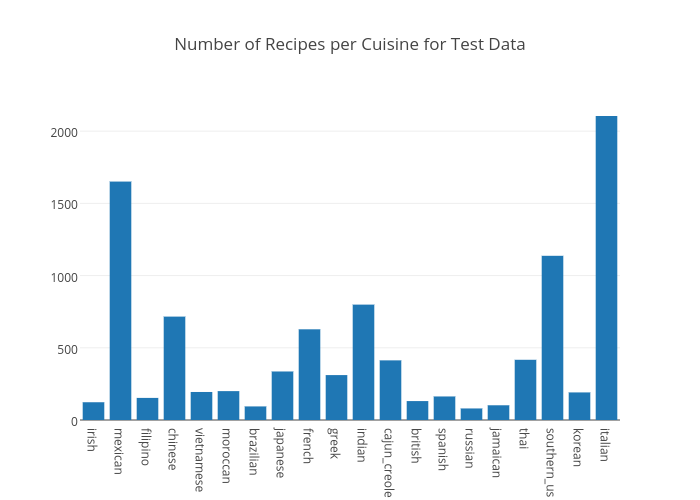

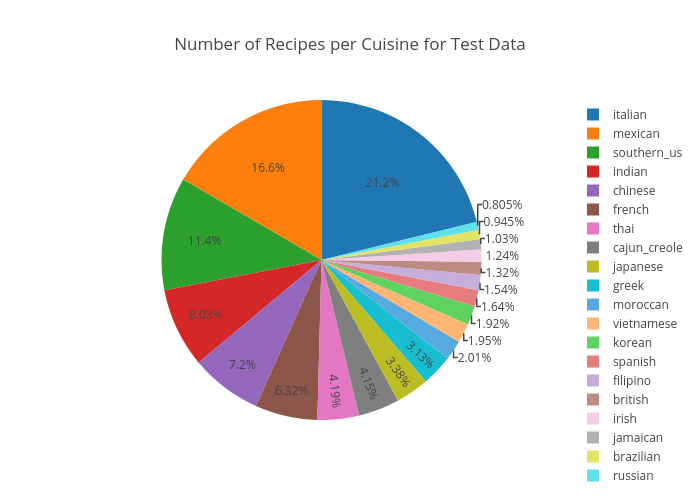

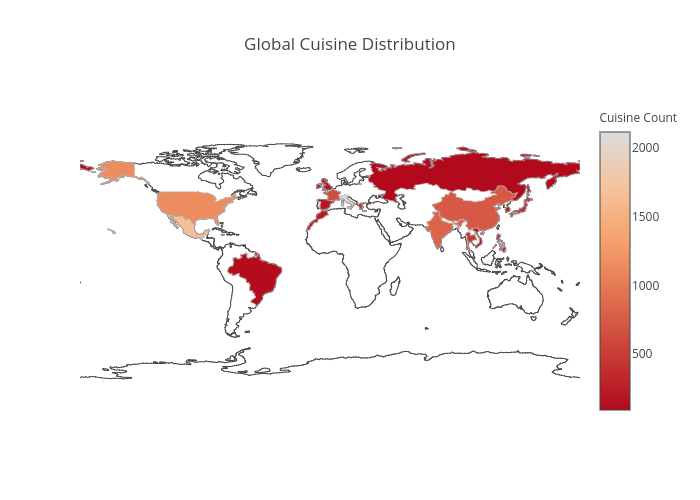

In [55]:
from collections import Counter

# Find Cuisine Distribution
countdict = Counter(test_df.cuisine)
cuisines = countdict.keys()
cuisinescount = countdict.values()

# Plot Cuisine Distribution Bar Chart
data = [
    go.Bar(
        y=cuisinescount,
        x=cuisines,    
    )
]
layout = dict(
    title='Number of Recipes per Cuisine for Test Data',
)
fig = go.Figure(data=data , layout=layout)


# Creating Pie Chart
fig2 = {
    'data': [{'labels': cuisines,
              'values': cuisinescount,
              'type': 'pie'}],
    'layout': {'title': 'Number of Recipes per Cuisine for Test Data'}
}

# Plot Global Cuisine Distribution

myList=[]

for c in cuisines: 
    if c == 'brazilian':
        myList.append('BRA')
    elif c == 'british':
        myList.append('GBR')
    elif c == 'cajun_creole':
        myList.append('USA')
    elif c == 'chinese':
        myList.append('CHN')
    elif c == 'filipino':
        myList.append('PHL')
    elif c == 'french':
        myList.append('FRA')
    elif c == 'greek':
        myList.append('GRC')
    elif c == 'indian':
        myList.append('IND')
    elif c == 'irish':
        myList.append('IRL')
    elif c == 'italian':
        myList.append('ITA')
    elif c == 'jamaican':
        myList.append('JAM')
    elif c == 'japanese':
        myList.append('JPN')
    elif c == 'korean':
        myList.append('KOR')
    elif c == 'mexican':
        myList.append('MEX')
    elif c == 'moroccan':
        myList.append('MAR')
    elif c == 'russian':
        myList.append('RUS')
    elif c == 'southern_us':
        myList.append('USA')
    elif c == 'spanish':
        myList.append('ESP')
    elif c == 'thai':
        myList.append('THA')
    elif c == 'vietnamese':
        myList.append('VNM')

data3 = [ dict(
        type = 'choropleth',
        locations = myList,
        z = cuisinescount,
        text = cuisines,
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = True,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            )
        ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Cuisine Count'
        ),
    ) ]

layout3 = dict(
    title = 'Global Cuisine Distribution',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
fig3 = dict( data=data3, layout=layout3 )

iplot(fig)
iplot(fig2)
iplot(fig3, validate=False)




# The code below is to display the static image of the plot
py.image.save_as(fig, 'Number of Recipes per Cuisine for Test Data Histogram.png')
py.image.save_as(fig2, 'Number of Recipes per Cuisine for Test Data Pie.png')
py.image.save_as(fig3, 'Global Cuisine Distribution Test Data.png')


py.image.ishow(fig)
py.image.ishow(fig2)
py.image.ishow(fig3)

<a id='Future Plans'></a>
#  Part 7 - Future Plans: Yummly Integration (Version 0.5.0) 

<img src="http://www.accuratech.in/images/futureplan_siteimage.jpg" width=300>

In this section an attempt was made to provide additional features beyond predicting cuisines from a set of ingredients. Project team ran out of time and could not complete this section.

In [36]:
from yummly import Client

# How to install Yummly
# pip install https://pypi.python.org/packages/py2.py3/y/yummly/yummly-0.5.0-py2.py3-none-any.whl
# pip install https://pypi.python.org/packages/py2.py3/y/yummly/ yummly-0.5.0.tar.gz

# About Yummly 
# https://pypi.python.org/pypi/yummly/0.5.0

# default option values
TIMEOUT = 5.0
RETRIES = 0
YOUR_API_ID = "c077aa3e"
YOUR_API_KEY = "0390dca06586895a80f9d7f549030bda"
client = Client(api_id=YOUR_API_ID, api_key=YOUR_API_KEY, timeout=TIMEOUT, retries=RETRIES)

search = client.search('green eggs and ham')
match = search.matches[0]

recipe = client.recipe(match.id)
print recipe

Recipe({'totalTime': u'12 min', 'rating': 3, 'attribution': Attribution({'url': u'http://www.yummly.com/recipe/Green-Eggs-and-Ham-Cups-1035325', 'text': u'Green Eggs and Ham Cups recipes: information powered by Yummly', 'html': u"<a href='http://www.yummly.com/recipe/Green-Eggs-and-Ham-Cups-1035325'>Green Eggs and Ham Cups recipe</a> information powered by <img alt='Yummly' src='http://static.yummly.com/api-logo.png'/>", 'logo': u'http://static.yummly.com/api-logo.png'}), 'totalTimeInSeconds': 720, 'ingredientLines': [u'4 large eggs', u"4 slices of precooked bacon (like the kind you can get at Costco and just need to reheat. You can also use completely raw bacon, but you will have to precook it until it's pink and almost done before adding your raw egg in)", u'about 3 tsp of pesto per egg'], 'numberOfServings': 4, 'flavors': Flavors({'piquant': None, 'sour': None, 'salty': None, 'sweet': None, 'bitter': None, 'meaty': None}), 'source': RecipeSource({'sourceSiteUrl': u'http://kirbiecrav

#### Search for recipes meeting certain criteria and limit your results to a maximum

In [ ]:
from yummly import Client

results = client.search('bacon', maxResults=1)

print('Total Matches:', results.totalMatchCount)
for match in results.matches:
    print('Recipe ID:', match.id)
    print('Recipe:', match.recipeName)
    print('Rating:', match.rating)
    print('Ingredients:')
    for ingred in match.ingredientLines:
        print(ingred)
    print('----------------------------------------------------')

#### Provide search parameters:

In [ ]:
params = {
    'q': 'pork chops',
    'start': 0,
    'maxResult': 40,
    'requirePicutres': False,
    'allowedIngredient[]': ['salt', 'pepper'],
    'excludedIngredient[]': ['cumin', 'paprika'],
    'maxTotalTimeInSeconds': 3600,
    'facetField[]': ['ingredient', 'diet'],
    'flavor.meaty.min': 0.5,
    'flavor.meaty.max': 1,
    'flavor.sweet.min': 0,
    'flavor.sweet.max': 0.5,
    'nutrition.FAT.min': 0,
    'nutrition.FAT.max': 15
}

results = client.search(**params, maxResults=1)

<img src="http://www.northernvirginiamag.com/wp-content/uploads/2012/04/shutterstock_70857532.jpg">